# Task IV: Quantum Generative Adversarial Network (QGAN)
You will explore how best to apply a quantum generative adversarial network (QGAN) to solve a High Energy Data analysis issue, more specifically, separating the signal events from the background events. You should use the Google Cirq and Tensorflow Quantum (TFQ) libraries for this task.
A set of input samples (simulated with Delphes) is provided in NumPy NPZ format [Download Input]. In the input file, there are only 100 samples for training and 100 samples for testing so it won’t take much computing resources to accomplish this
task. The signal events are labeled with 1 while the background events are labeled with 0.
Be sure to show that you understand how to fine tune your machine learning model to improve the performance. The performance can be evaluated with classification accuracy or Area Under ROC Curve (AUC).




---



---



# What is QGAN?
Quantum Generative Adversarial Networks (QGANs) are quantum machine learning models inspired by classical Generative Adversarial Networks (GANs). They consist of a **quantum generator** and a **classical or quantum discriminator** that compete to generate data resembling a target distribution. The generator produces quantum states that the discriminator evaluates, improving both components through iterative training.

QGANs leverage quantum advantages, such as exponential Hilbert space growth, to model complex probability distributions efficiently. They have applications in financial modeling, data augmentation, and quantum simulation where classical GANs struggle with high-dimensional distributions.

*Analogous to the competition between counterfeiters who have to produce fake currencies and the police who have to design methods to distinguish increasingly more convincing counterfeits from the real ones. This game has a Nash equilibrium where the fake coins become indistinguishable from the real ones and the authorities can no longer devise a method to discriminate the real currencies from the generated ones. Interestingly, theoretical proofs regarding the optimal points of adversarial training assume that the generator and discriminator have infinite capacity, i.e., they can encode arbitrary functions or probability distributions. Yet it is widely believed that classical computers cannot efficiently solve certain hard problems, so these optimal points may be intrinsically out of reach of classical models in many cases of interest.[1]*



---



---



In [ ]:
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import sympy
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from cirq.contrib.svg import SVGCircuit

# Step1: Understanding the Dataset
This dataset consists of simulated jet classification samples generated using Delphes, a fast detector simulation framework.

**Dataset Overview:**
*  **Total Samples: 200**
*  Training Samples: 100
*  Testing Samples: 100


*  **Labels**:
*  **Signal Events (1)** – Represent jets originating from the desired physics process.
* **Background Events (0)** – Represent jets from other, less relevant processes.










In [ ]:
file_path = r"C:\Users\vedav\Downloads\QIS_EXAM_200Events.npz"
data = np.load(file_path)
print(data.files)

['training_input', 'test_input']


In [ ]:
data = np.load(file_path, allow_pickle=True)
print("Dataset keys:", data.files)  # Ensure correct keys

# Extract training and testing data
train_data = data['training_input'].item()  # Convert to dictionary
test_data = data['test_input'].item()       # Convert to dictionary

# Combine signal (1) and background (0) events
X_train = np.vstack([train_data['0'], train_data['1']])
y_train = np.hstack([np.zeros(len(train_data['0'])), np.ones(len(train_data['1']))])
X_test = np.vstack([test_data['0'], test_data['1']])
y_test = np.hstack([np.zeros(len(test_data['0'])), np.ones(len(test_data['1']))])

# Print shapes to verify correctness
print(f"Training samples shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing samples shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")


Dataset keys: ['training_input', 'test_input']
Training samples shape: (100, 5)
Training labels shape: (100,)
Testing samples shape: (100, 5)
Testing labels shape: (100,)


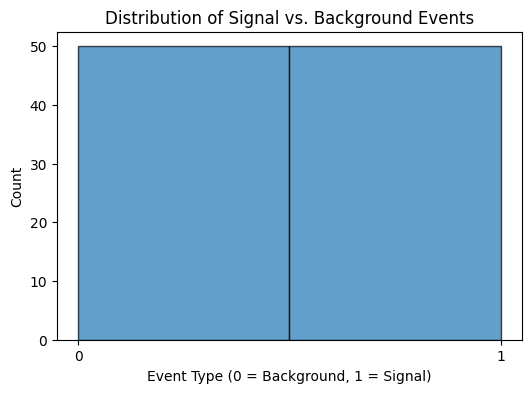

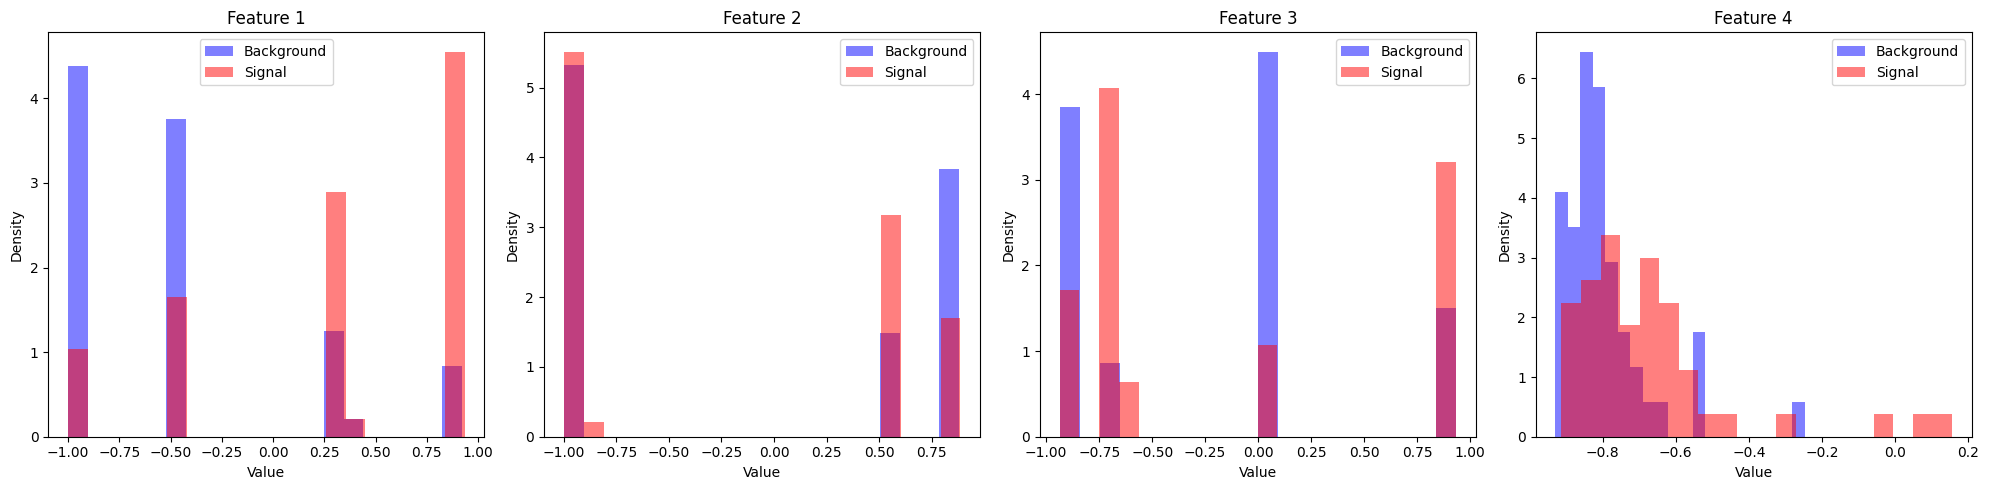

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(y_train, bins=2, edgecolor="black", alpha=0.7)
plt.xticks([0, 1])
plt.xlabel("Event Type (0 = Background, 1 = Signal)")
plt.ylabel("Count")
plt.title("Distribution of Signal vs. Background Events")
plt.show()
num_features = X_train.shape[1]  # Number of features in the dataset

# Plot histograms for first few features
fig, axes = plt.subplots(1, 4, figsize=(20,5))  # Adjust to plot more features if needed
for i in range(4):  # Change this to plot more features
    axes[i].hist(X_train[y_train == 0][:, i], bins=20, alpha=0.5, label="Background", color="blue", density=True)
    axes[i].hist(X_train[y_train == 1][:, i], bins=20, alpha=0.5, label="Signal", color="red", density=True)
    axes[i].set_title(f"Feature {i+1}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Density")
    axes[i].legend()

plt.tight_layout()
plt.show()



---



---



# Step2: Data Encoding Circuit

The data encoding circuit transforms classical high energy physics data into quantum states that can be processed by quantum algorithms. This is a crucial step because quantum computers operate on quantum information (qubits in superposition and entanglement states), not classical bits.

Common encoding methods include amplitude encoding (representing data in probability amplitudes), angle encoding (encoding features as rotation angles of qubits), or basis encoding (direct binary representation)

# Angle Encoding for HEP Data with 5 Features
Angle encoding (also called rotation encoding) is a quantum encoding technique that maps classical data features to rotation angles of qubits.
# Why Angle Encoding Is Useful for HEP Data
Angle encoding offers several advantages for our signal/background classification task:
* **Direct physical interpretation** : Rotation angles can represent physical quantities like angles, energies, or momenta that are common in HEP data.
* **Efficient use of qubits** : Each feature requires only one qubit, making it resource-efficient for our 5-feature dataset.
* **Expressive power**: Rotations can represent continuous values, preserving the fine-grained information in our data that might be crucial for signal/background separation.
* **Compatible with variational circuits**: Angle-encoded data works seamlessly with the parameterized quantum circuits used in QGANs.
* **Noise resilience**: Compared to some other encoding methods, angle encoding can be more robust to certain types of quantum noise.

For HEP applications, where features often represent physical quantities with meaningful distributions, angle encoding provides a natural way to map this classical information into the quantum domain while preserving the important patterns needed for effective discrimination between signal and background events.





# How Angle Encoding Works



*   Each feature value is normalized, typically to the range [0, 2π]
*   The normalized value is used as the rotation angle for a quantum gate
*  Common rotation gates include Rx (rotation around X-axis), Ry (Y-axis), or Rz (Z-axis)

For our 5-feature HEP dataset, we would typically use 5 qubits, with each qubit encoding one feature through rotation gates.






In [ ]:
# Step 1: Convert labels from 0/1 to bipolar (-1/1) format and add an extra column
def transform_labels(labels):
    # Convert scalar labels to one-hot vectors: 0 -> [1,0] and 1 -> [0,1]
    one_hot = tf.keras.utils.to_categorical(labels)
    # Scale to bipolar: [1,0] becomes [1, -1] and [0,1] becomes [-1, 1]
    bipolar = one_hot * 2 - 1
    # Append an extra column of ones (can be used for bias or auxiliary info)
    extra_col = np.ones((len(labels), 1))
    return np.concatenate((bipolar, extra_col), axis=1)

# Transform training and testing labels
y_train_mod = transform_labels(y_train)
y_test_mod = transform_labels(y_test)
print("Modified label shapes:", y_train_mod.shape, y_test_mod.shape)  # Expected: (100, 3) for both

# Step 2: Encode classical features into quantum circuits using angle encoding.
def encode_features_to_quantum(data, qubit_array):
    """Encodes classical data into quantum circuits using a mixed angle encoding.

    For each sample, applies RX to the first half of the features and RY to the second half.
    """
    quantum_circuits = []
    for sample in data:
        circuit = cirq.Circuit()
        for idx, feature in enumerate(sample):
            # Apply RX rotation for the first half of the features, RY for the rest.
            if idx < len(sample) // 2:
                circuit.append(cirq.rx(feature)(qubit_array[idx]))
            else:
                circuit.append(cirq.ry(feature)(qubit_array[idx]))
        quantum_circuits.append(circuit)
    return quantum_circuits

# We have 5 features, so we create a 1x5 grid of qubits.
quantum_register = cirq.GridQubit.rect(1, 5)

# Step 3: Convert the classical data into quantum circuits, then into TFQ tensors.
train_quantum_tensors = tfq.convert_to_tensor(encode_features_to_quantum(X_train, quantum_register))
test_quantum_tensors = tfq.convert_to_tensor(encode_features_to_quantum(X_test, quantum_register))

# Step 4: Inspect the quantum circuits for both event types.
# Here we assume the first column in y_train_mod indicates the label:
# - Background event: first element is -1 (from original 0 label)
# - Signal event: first element is 1 (from original 1 label)
print("Example quantum circuit for a background event (label -1):")
print(tfq.from_tensor(train_quantum_tensors)[y_train_mod[:, 0] == -1][0])
print("\nExample quantum circuit for a signal event (label 1):")
print(tfq.from_tensor(train_quantum_tensors)[y_train_mod[:, 0] == 1][0])

Modified label shapes: (100, 3) (100, 3)
Example quantum circuit for a background event (label -1):
(0, 0): ───Rx(-0.135π)───

(0, 1): ───Rx(0.282π)────

(0, 2): ───Ry(-0.298π)───

(0, 3): ───Ry(-0.207π)───

(0, 4): ───Ry(-0.125π)───

Example quantum circuit for a signal event (label 1):
(0, 0): ───Rx(-0.137π)───

(0, 1): ───Rx(0.276π)────

(0, 2): ───Ry(-0.295π)───

(0, 3): ───Ry(-0.295π)───

(0, 4): ───Ry(-0.181π)───




---



---



# Step3: Defining Quantum Generator
A quantum generator is the component of a Quantum Generative Adversarial Network (QGAN) that aims to generate quantum states which mimic the distribution of the real data. Just like its classical counterpart in a GAN, it is a parameterized quantum circuit whose parameters are adjusted during training. When measured, the quantum circuit produces outcomes that should approximate the true data distribution, effectively creating synthetic data that is hard to distinguish from actual data by the discriminator.

**Parameterized Quantum Circuit**
*   **Structure**:The quantum generator is built as a parameterized (or variational) quantum circuit. This circuit contains a series of quantum gates (e.g., rotations, entangling gates) whose angles or other parameters can be adjusted.
* **Variational Parameters**:These parameters are optimized during training so that the quantum circuit produces output states that resemble the target data distribution. Think of these parameters as analogous to the weights in a classical neural network.

**Data Generation Process**
* **Quantum State Preparation**:
The generator takes an initial quantum state—often a simple state like
∣0⟩
^(⊗n)
  (all qubits in the ground state)—and applies a sequence of parameterized gates.
* **Encoding Randomness**:
Similar to classical generators that use random noise vectors as input, the quantum generator can incorporate randomness through parameters or measurement outcomes, thereby introducing variability into the generated states.
* **Measurement:**After the quantum circuit is applied, measurements are performed on the qubits. The measurement outcomes are interpreted as samples drawn from the generated quantum data distribution. This step transforms the quantum state into classical data that can be compared with real samples.

**Loss Optimization:**

During training, the loss function penalizes the generator when the discriminator successfully identifies its output as fake. Optimization algorithms (like gradient descent or quantum-aware versions thereof) adjust the variational parameters in the quantum generator, aiming to reduce this loss.

**Example:**

For instance, a quantum generator might consist of layers of single-qubit rotations (e.g., RX, RY, or RZ gates) and entangling gates (like CNOTs) arranged in a circuit. As the training proceeds, these layers are tuned to produce output states that, after measurement, yield data closely matching the statistical properties of the real dataset.

In [ ]:
def custom_one_qubit_gate(q, angle_params):
    """Applies a sequence of rotations about the Z, X, and Y axes in that order."""
    return cirq.Circuit(
        cirq.rz(angle_params[0])(q),
        cirq.rx(angle_params[1])(q),
        cirq.ry(angle_params[2])(q)
    )

def custom_two_qubit_gate(q1, q2, angle_params):
    """Constructs a two-qubit operation by applying custom one-qubit gates to each qubit,
    followed by an entangling CZ gate raised to a parameter, and concluding with additional rotations.

    Expects angle_params to have 13 elements:
      - First 3 for q1, next 3 for q2,
      - One for the CZ entangling gate,
      - Final 6 for additional rotations (3 for q1, 3 for q2).
    """
    circuit = cirq.Circuit()
    # First round of single-qubit gates
    circuit += custom_one_qubit_gate(q1, angle_params[0:3])
    circuit += custom_one_qubit_gate(q2, angle_params[3:6])
    # Entangling operation using CZ raised to a given power
    circuit.append(cirq.CZ(q1, q2)**angle_params[6])
    # Second round of single-qubit gates
    circuit += custom_one_qubit_gate(q1, angle_params[7:10])
    circuit += custom_one_qubit_gate(q2, angle_params[10:13])
    return circuit

def custom_generator_circuit(qubits, param_list, num_layers=1):
    """
    Builds a custom parameterized quantum generator circuit.

    Args:
        qubits (list[cirq.Qid]): List of qubits used in the circuit.
            All qubits are involved in the generation process.
        param_list (list or array-like): List of parameters (numeric or sympy.Symbol) for the gate operations.
        num_layers (int, optional): The number of circuit layers. Defaults to 1.

    Returns:
        cirq.Circuit: The constructed quantum generator circuit.
    """
    circuit = cirq.Circuit()
    num_qubits = len(qubits)

    # --- Initial Rotations ---
    # Apply a random RY rotation to each qubit using uniformly random angles.
    init_angles = np.random.uniform(0, 2*np.pi, num_qubits)
    for i, q in enumerate(qubits):
        circuit.append(cirq.ry(init_angles[i])(q))

    # Keep track of our current position in the parameter list.
    param_idx = 0

    # --- Layered Circuit Structure ---
    for layer in range(num_layers):
        # Sub-layer A: Apply single-qubit rotations to each qubit.
        for i, q in enumerate(qubits):
            # Each qubit gets 3 parameters
            angles = param_list[param_idx:param_idx+3]
            param_idx += 3
            circuit += custom_one_qubit_gate(q, angles)

        # Sub-layer B: Introduce entanglement between adjacent qubits.
        for i in range(num_qubits - 1):
            # For each adjacent pair, use 13 parameters in the custom two-qubit gate.
            two_qubit_params = param_list[param_idx:param_idx+13]
            param_idx += 13
            circuit += custom_two_qubit_gate(qubits[i], qubits[i+1], two_qubit_params)

    # --- Final Adjustment ---
    # Optionally, apply an extra round of one-qubit rotations to the first half of the qubits.
    half = num_qubits // 2
    for i in range(half):
        angles = param_list[param_idx:param_idx+3]
        param_idx += 3
        circuit += custom_one_qubit_gate(qubits[i], angles)

    return circuit

# Example usage:
# Create a list of 6 qubits for the generator.
qubit_list = cirq.GridQubit.rect(1, 6)

# Assume we have a total of 6 qubits, num_layers=2, then we need to supply enough parameters.
# For each layer:
#   - Single-qubit operations: 6 qubits * 3 = 18 parameters.
#   - Entangling gates: 5 pairs * 13 = 65 parameters.
# For 2 layers: (18 + 65)*2 = 166 parameters.
# Plus final adjustments on half (3 qubits * 3 = 9 parameters).
# Total = 166 + 9 = 175 parameters.
# Here we create a list of symbolic parameters for demonstration.
params = [sympy.Symbol(f'theta_{i}') for i in range(175)]
generator_circuit = custom_generator_circuit(qubit_list, params, num_layers=2)
print(generator_circuit)

(0, 0): ───Ry(0.154π)───Rz(theta_0)───Rx(theta_1)───Ry(theta_2)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rz(theta_18)───Rx(theta_19)───Ry(theta_20)────────────────────────────────────────────────@────────────Rz(theta_25)───Rx(theta_26)───Ry(theta_27)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



---



---



# Step4: Defining Quantum Discriminator
A quantum discriminator is a parameterized quantum circuit designed to evaluate whether an input quantum state is real (from the actual dataset) or fake (generated by the quantum generator). It processes quantum data through layers of single-qubit rotations and entangling gates, ultimately producing a measurement that serves as a classification output. During adversarial training, the discriminator's goal is to maximize its ability to distinguish between genuine and synthetic quantum states, thereby driving the generator to improve the quality of its produced states.










In [ ]:
import numpy as np
import cirq
import sympy

def disc_single_qubit_gate(q, angle_vals):
    """
    Applies a custom single-qubit gate to qubit 'q' using the sequence RX -> RZ -> RX.

    Args:
        q (cirq.Qid): The qubit to operate on.
        angle_vals (list): List of 3 rotation parameters.

    Returns:
        cirq.Circuit: A circuit segment implementing the gate.
    """
    return cirq.Circuit(
        cirq.rx(angle_vals[0])(q),
        cirq.rz(angle_vals[1])(q),
        cirq.rx(angle_vals[2])(q)
    )

def disc_two_qubit_gate(q1, q2, angle_vals):
    """
    Constructs a custom two-qubit gate that entangles q1 and q2.
    This gate applies:
      - A single-qubit gate on q1,
      - A CNOT from q1 to q2,
      - A single-qubit gate on q2,
      - A CZ gate raised to a parameter,
      - A final single-qubit gate on q1.

    Expects angle_vals to be a list of 10 parameters:
      - First 3 for q1,
      - Next 3 for q2,
      - One for the CZ entanglement,
      - Final 3 for an extra rotation on q1.

    Args:
        q1 (cirq.Qid): First qubit.
        q2 (cirq.Qid): Second qubit.
        angle_vals (list): List of 10 parameters.

    Returns:
        cirq.Circuit: A circuit segment implementing the two-qubit operation.
    """
    circuit = cirq.Circuit()
    circuit += disc_single_qubit_gate(q1, angle_vals[0:3])
    circuit.append(cirq.CNOT(q1, q2))
    circuit += disc_single_qubit_gate(q2, angle_vals[3:6])
    circuit.append(cirq.CZ(q1, q2)**angle_vals[6])
    circuit += disc_single_qubit_gate(q1, angle_vals[7:10])
    return circuit

def custom_discriminator_circuit(qubits, param_list, num_layers=1):
    """
    Builds a custom parameterized quantum discriminator circuit using 6 qubits.

    This circuit applies single-qubit rotations and entangling two-qubit gates across multiple layers.
    The final measurement on a designated qubit produces a classical output for discrimination.

    Args:
        qubits (list[cirq.Qid]): List of 6 qubits to be used in the circuit.
        param_list (list or array-like): List of parameters (numeric or sympy.Symbol) for the gate operations.
        num_layers (int, optional): Number of layers in the circuit. Defaults to 1.

    Returns:
        cirq.Circuit: The constructed discriminator circuit.
    """
    circuit = cirq.Circuit()
    num_qubits = len(qubits)
    param_idx = 0

    # For each layer, apply single-qubit gates and two-qubit entangling gates between adjacent qubits.
    for layer in range(num_layers):
        # Single-qubit operations: Each of 6 qubits gets 3 parameters → 6*3 = 18 parameters per layer.
        for i, q in enumerate(qubits):
            angles = param_list[param_idx:param_idx+3]
            param_idx += 3
            circuit += disc_single_qubit_gate(q, angles)

        # Entangling operations: For 6 qubits, there are 5 adjacent pairs, each requiring 10 parameters → 5*10 = 50 per layer.
        for i in range(num_qubits - 1):
            two_qubit_angles = param_list[param_idx:param_idx+10]
            param_idx += 10
            circuit += disc_two_qubit_gate(qubits[i], qubits[i+1], two_qubit_angles)

    # Final measurement: measure the first qubit (or you could measure multiple qubits) to yield the discriminator output.
    circuit.append(cirq.measure(qubits[0], key='result'))

    return circuit

# Example usage with 6 qubits and 2 layers:
num_qubits_disc = 6
qubit_set_disc = cirq.GridQubit.rect(1, num_qubits_disc)

# Parameter count per layer:
# - Single-qubit gates: 6 * 3 = 18 parameters.
# - Two-qubit gates: 5 pairs * 10 = 50 parameters.
# Total per layer = 18 + 50 = 68 parameters.
# For 2 layers: 68 * 2 = 136 parameters.
params_disc = [sympy.Symbol(f'phi_{i}') for i in range(136)]

discriminator_circuit = custom_discriminator_circuit(qubit_set_disc, params_disc, num_layers=2)
print(discriminator_circuit)


(0, 0): ───Rx(phi_0)───Rz(phi_1)───Rx(phi_2)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rx(phi_18)───Rz(phi_19)───Rx(phi_20)───@──────────────────────────────────────────@──────────Rx(phi_25)───Rz(phi_26)───Rx(phi_27)───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rx(phi_68)───Rz(phi_69)───Rx(phi_70)─────────────────────────────────────────────────────────────────────



---



---



#  Step5: Defining the Loss Functions


* **Adversarial Loss:** We develop separate loss functions for the generator and discriminator. For example, the discriminator should correctly classify real vs. fake samples, while the generator should try to "fool" the discriminator.

**Discriminator Loss:**
The discriminator’s loss is designed to penalize misclassification of both real (encoded from the data) and fake (generated by the quantum generator) samples. A common approach is to use binary cross-entropy loss. For real samples
𝑥
 (which should be classified as 1) and fake samples
𝐺
(
𝑧
)
(which should be classified as 0), the loss can be formulated as:
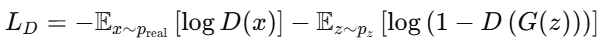





**Generator Loss**:
The generator’s goal is to "fool" the discriminator, meaning it aims to generate samples that the discriminator classifies as real. Thus, its loss encourages the discriminator’s output on generated samples
𝐺
(
𝑧
)
 to be high (close to 1). This is also typically implemented with binary cross-entropy:
 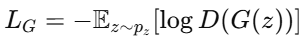

* **Metric-Based Loss:**Consider incorporating metrics like classification accuracy or AUC as part of your evaluation.

In [ ]:
import tensorflow as tf

def discriminator_loss(real_output, fake_output):
    """
    Computes the discriminator loss using hinge loss for bipolar labels.

    Args:
        real_output: Discriminator predictions for real samples.
        fake_output: Discriminator predictions for fake (generated) samples.

    Returns:
        Total discriminator loss.
    """
    # For real samples, we want D(x) to be >= 1. Otherwise, loss = 1 - D(x)
    real_loss = tf.reduce_mean(tf.nn.relu(1 - real_output))

    # For fake samples, we want D(G(z)) to be <= -1. Otherwise, loss = 1 + D(G(z))
    fake_loss = tf.reduce_mean(tf.nn.relu(1 + fake_output))

    return real_loss + fake_loss

def generator_loss(fake_output):
    """
    Computes the generator loss using hinge loss for bipolar labels.

    Args:
        fake_output: Discriminator predictions for fake (generated) samples.

    Returns:
        Generator loss (aiming to maximize discriminator output).
    """
    # The generator tries to push fake outputs to be classified as real (i.e., to be high).
    # Thus, the generator loss is the negative of the mean discriminator output on fake samples.
    return -tf.reduce_mean(fake_output)


# Step6: Training

In [ ]:
observable = cirq.Z(quantum_register[0])

# Since the generator circuit is fully parameterized and does not take classical noise,
# we feed an "empty" circuit as input.
num_samples = train_quantum_tensors.shape[0]
empty_circuits = tfq.convert_to_tensor([cirq.Circuit() for _ in range(num_samples)])

# Build the generator model.
generator_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(generator_circuit, observable)
])

# Build the discriminator model.
discriminator_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(discriminator_circuit, observable)
])

# Define optimizers.
optimizer_g = tf.keras.optimizers.Adam(learning_rate=0.01)
optimizer_d = tf.keras.optimizers.Adam(learning_rate=0.01)

# Training step function.
@tf.function
def train_step(real_circuits, noise_circuits):
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake quantum data.
        fake_output_gen = generator_model(noise_circuits)
        # Discriminator outputs on real and fake data.
        disc_real = discriminator_model(real_circuits)
        disc_fake = discriminator_model(fake_output_gen)
        # Compute losses.
        d_loss = discriminator_loss(disc_real, disc_fake)
        g_loss = generator_loss(disc_fake)
    grads_d = tape.gradient(d_loss, discriminator_model.trainable_variables)
    grads_g = tape.gradient(g_loss, generator_model.trainable_variables)
    del tape
    optimizer_d.apply_gradients(zip(grads_d, discriminator_model.trainable_variables))
    optimizer_g.apply_gradients(zip(grads_g, generator_model.trainable_variables))
    return d_loss, g_loss

# Create a tf.data.Dataset for training.
batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices((train_quantum_tensors, empty_circuits))
dataset = dataset.shuffle(buffer_size=100).batch(batch_size)

# Training loop.
epochs = 20
for epoch in range(epochs):
    d_losses, g_losses = [], []
    for real_batch, noise_batch in dataset:
        d_loss_val, g_loss_val = train_step(real_batch, noise_batch)
        d_losses.append(d_loss_val)
        g_losses.append(g_loss_val)
    print(f"Epoch {epoch+1}: Discriminator Loss = {tf.reduce_mean(d_losses):.4f}, Generator Loss = {tf.reduce_mean(g_losses):.4f}")

Beyond this point i have been facing issues which are taking long to debug I plan on coming back and resolving them once I am done with the other tasks:(

# Steps yet to be worked upon:


*  Training the model .
*  Adjusting parameters for best generator and discriminator losses.





---



---



The current approach of using a Quantum Generative Adversarial Network (QGAN) for high-energy physics event classification has several limitations that make it suboptimal. First, quantum circuits are still noisy and simulated quantum computations do not provide a real quantum advantage, making classical GANs or Variational Quantum Classifiers (VQCs) potentially more effective. Additionally, GANs are notoriously difficult to train due to instability issues like mode collapse, where the generator fails to learn meaningful variations, and the discriminator overpowering the generator. The feature encoding method, which scales classical data to (-π, π) for quantum circuit inputs, may also distort important relationships, limiting the model’s effectiveness. Moreover, the computational cost of simulating quantum circuits is high, and training on real quantum hardware introduces additional noise, making fully classical models or hybrid quantum-classical approaches more efficient. The chosen latent space dimension (4) might not be expressive enough for high-energy physics distributions, leading to loss of crucial event characteristics. Finally, the evaluation metrics are limited, as the model is only trained with binary cross-entropy loss instead of physics-informed metrics like Wasserstein distance or Kullback-Leibler divergence, which are crucial for validating generated distributions. To improve this approach, one could benchmark against classical GANs, test hybrid quantum-classical encodings, incorporate physics-informed loss functions, or explore Variational Autoencoders (VAEs) and Normalizing Flows, which may offer greater stability and more accurate data generation.